Preamble
=======

Need to find a *unique* CDS start position for each protein encoding locus.

Load up data, find model with longest ORF
    1. Check this against the TAIR10 rep model
    2. Check how many transcript match this vs the number with upstream or downstream ATGs



In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles

% matplotlib inline

In [3]:
class Gene(object):
    def __init__(self, name):
        assert name.startswith('AT')
        self.name = name
        self.transcript_dict = {}
        self.repr_model = ''
        self.atg_list = []
        self.rep_atg = ''
        self.transposon = False
        
    def add_sense(self, sense):
        assert sense == '-' or sense == '+'
        self.sense = sense
        
    def add_feature_tair(self, line_fields):
        '''
        Take information from a line of a GFF3 file and use it to
        populate an instance of the Gene model.
        This method is particular to TAIR10, where the GFF3 file is
        arranged differently to Araport11
        '''
        # use parent info to get model_id
        feature = line_fields[8]
        if line_fields[2] == 'mRNA':
            transcript_ID = feature[3:14]
        else:
            if feature.startswith('Parent='): # TAIR10 style
                feature = feature.split(',')
                transcript_ID = feature[0][7:]

        assert transcript_ID.startswith('AT')
        assert transcript_ID[:9] == self.name
        
        if transcript_ID not in self.transcript_dict:
            transcript_model = Transcript(transcript_ID)
            transcript_model.sense = line_fields[6]
            self.transcript_dict.update({transcript_ID:transcript_model})
        transcript_model = self.transcript_dict[transcript_ID]
        
        if line_fields[2] == 'mRNA':
            transcript_ID = feature[3:14]
            mRNA_bounds = [line_fields[3], line_fields[4]]
            transcript_model.mRNA = mRNA_bounds    
  
        if line_fields[2] == 'CDS':# and proteinCoding == True:
            cds_coords = [int(line_fields[3]), int(line_fields[4])]
            transcript_model.add_CDS(cds_coords)

        if line_fields[2] == 'exon':# and proteinCoding == True:
            exon_coords = [int(line_fields[3]), int(line_fields[4])]
            transcript_model.add_exon(exon_coords)
        self.transcript_dict.update({transcript_ID:transcript_model})
        
        
    def add_feature_araport(self, line_fields):
        '''
        Take information from a line of a GFF3 file and use it to
        populate an instance of the Gene model.
        This method is particular to Araport11, where the GFF3 file is
        arranged differently to TAIR10:
        While TAIR10 lists each exon, cds etc on an individual line for
        each transcript model, Araport11 lists all the transcripts
        that contain that feature.
        '''
        feature = line_fields[8]
        if 'retrotransposon' in feature:
            self.transposon = True
        if line_fields[2] == 'mRNA':
            transcript_ID_list = [feature[3:14]]
        else:
            if feature.startswith('ID='): # Araport11 style
                feature = feature.split(';')
                transcript_ID_list = feature[1][7:].split(',')

        for transcript_ID in transcript_ID_list:
            assert transcript_ID.startswith('AT')
            assert transcript_ID[:9] == self.name
            
            if transcript_ID not in self.transcript_dict:
                transcript_model = Transcript(transcript_ID)
                transcript_model.sense = line_fields[6]
                self.transcript_dict.update({transcript_ID:transcript_model})
            transcript_model = self.transcript_dict[transcript_ID]
            
            if line_fields[2] == 'mRNA':
                transcript_ID = feature[3:14]
                mRNA_bounds = [line_fields[3], line_fields[4]]
                transcript_model.mRNA = mRNA_bounds

            if line_fields[2] == 'CDS':# and proteinCoding == True:
                cds_coords = [int(line_fields[3]), int(line_fields[4])]
                transcript_model.add_CDS(cds_coords)

            if line_fields[2] == 'exon':# and proteinCoding == True:
                exon_coords = [int(line_fields[3]), int(line_fields[4])]
                transcript_model.add_exon(exon_coords)
            self.transcript_dict.update({transcript_ID:transcript_model})
        return

    def get_atg_list(self):
        atg_list = [[],[]]
        for transcript_ID in self.transcript_dict:
            transcript_model = self.transcript_dict[transcript_ID]
            atg = transcript_model.get_atg()
            atg_list[0].append(transcript_ID)
            atg_list[1].append(atg)
        return atg_list
    
    def get_orf_lengths(self):
        orf_lengths = [[],[]]
        for transcript_ID in self.transcript_dict:
            transcript_model = self.transcript_dict[transcript_ID]
            orf_length = transcript_model.get_orf_length()
            orf_lengths[0].append(transcript_ID)
            orf_lengths[1].append(orf_length)
        return orf_lengths
   
    def mRNA_lengths(self):
        mRNA_lengths = [[],[]]
        for transcript_ID in self.transcript_dict:
            transcript_model = self.transcript_dict[transcript_ID]
            mRNA = transcript_model.mRNA
            if mRNA == None: # non-coding transcript model at a coding locus
                continue
            mRNA_length = 1 + int(mRNA[1]) - int(mRNA[0])
            mRNA_lengths[0].append(transcript_ID)
            mRNA_lengths[1].append(mRNA_length)
        return mRNA_lengths
              
    def add_bounds(self, bounds):
        self.boundaries = bounds
        return

#############################################################################################
        
        
class Transcript(object):
    def __init__(self, name):
        self.name = name
        self.sense = None
        self.mRNA = None
        self.exon_list = []
        self.cds_list = []
        self.orf = []
        self.seq = ''
        self.cds_trim_seq = ''

    def add_exon(self, exon):
        if exon not in self.exon_list:	# instances in Yamile's data of duplicate transcript descriptions
            self.exon_list.append(exon)
            self.exon_list.sort()
        else: pass
    def add_CDS(self, cds):
        self.cds_list.append(cds)
        self.cds_list.sort()
        self.orf = [self.cds_list[0][0], self.cds_list[-1][1]]
    def add_ORF(self, ORF):
        self.orf = ORF     
    def get_atg(self):
        if self.sense == '+' and self.cds_list != []:
            return self.cds_list[0][0]
        elif self.sense == '-' and self.cds_list != []:
            return self.cds_list[-1][1]
        else: return # There is one transcript, AT1G77080.1, that has no annotated CDS
            
    def get_orf_length(self):
        if self.cds_list != []:
            return 1 + self.cds_list[-1][1] - self.cds_list[0][0]
        else: return

#############################################################################################

In [4]:
def add_locus_model(locus_dict, line_fields):
    locus_ID = line_fields[8][3:12]
    if locus_ID not in locus_dict: # necessary? surely only one instance of each 
        gene_model = Gene(locus_ID)
    else:
        print locus_ID + ": more than one instance in GFF file"
        gene_model = locus_dict[locus_ID]

    gene_coords = [int(line_fields[3]), int(line_fields[4])]
    gene_model.add_bounds(gene_coords)
    gene_model.add_sense(line_fields[6])
    locus_dict.update({locus_ID: gene_model})
    return locus_dict


def get_models(gff_lines, source):
    locus_dict = {}
    for line in gff_lines:
        line=line.strip()
        if line.startswith('#'):
            continue
        line_fields = line.split('\t')
        if line_fields[2] == 'chromosome':
            continue
        if line_fields[2] == 'protein':
            continue
        
        if line_fields[2][-4:] == 'gene':                      #second index allows for 'genes' and 'transposable_element_gene' etc
            if line_fields[8][18:37] != 'protein_coding_gene' and source == 'tair':
                proteinCoding = False
                continue
            else:
                proteinCoding = True
                locus_ID = line_fields[8].split(';')[0][3:12]
                if not locus_ID.startswith('AT'):
                    print line
                locus_dict = add_locus_model(locus_dict, line_fields)
        else:
            if proteinCoding is True:# need proteinCoding is True to pass through here
                locus_model = locus_dict[locus_ID]
                if source == 'tair':
                    locus_model.add_feature_tair(line_fields)
                if source == 'araport':
                    locus_model.add_feature_araport(line_fields)
    return locus_dict



def calc_venn_sizes(A,B,C):
    a = A.difference(B).difference(C)
    b = B.difference(A).difference(C)
    c = A.intersection(B).difference(C)
    d = C.difference(A).difference(B)
    e = A.intersection(C).difference(B)
    f = B.intersection(C).difference(A)
    g= A.intersection(B).intersection(C)

    # Subset sizes
    s = (
        len(a),    # Abc
        len(b),    # aBc
        len(c),    # ABc
        len(d),    # abC
        len(e),    # AbC
        len(f),  # aBC
        len(g)    # ABC
    )
    return s



def format_venn(v):
    # Subset labels
    v.get_label_by_id('100').set_text('Abc')
    v.get_label_by_id('010').set_text('aBc')
    v.get_label_by_id('110').set_text('ABc')
    v.get_label_by_id('001').set_text('Abc')
    v.get_label_by_id('101').set_text('aBc')
    v.get_label_by_id('011').set_text('ABc')
    v.get_label_by_id('111').set_text('ABC')

    # Subset colors
    v.get_patch_by_id('100').set_color('c')
    v.get_patch_by_id('010').set_color('#993333')
    v.get_patch_by_id('110').set_color('blue')
   
    # Subset alphas
    v.get_patch_by_id('101').set_alpha(0.4)
    v.get_patch_by_id('011').set_alpha(1.0)
    v.get_patch_by_id('111').set_alpha(0.7)

    # Border styles
    c = venn3_circles(subsets=s, linestyle='solid')
    c[0].set_ls('dotted')  # Line style
    c[1].set_ls('dashed')
    c[2].set_lw(1.0)       # Line width
    return v


In [5]:
infile = open('./TAIR10_GFF3_genes.gff', 'rU')
gff_lines = infile.readlines()
infile.close()
tair = get_models(gff_lines, 'tair')

infile = open('./Araport11_genes.20151202.gff3', 'rU')
gff_lines = infile.readlines()
infile.close()
araport = get_models(gff_lines, 'araport')

infile = open('./Araport11_genes.20151202.gff3', 'rU')
gff_lines = infile.readlines()
infile.close()
araport2 = get_models(gff_lines, 'araport')

infile = open('./TAIR10_representative_gene_models.txt')
lines = infile.readlines()
infile.close()

rep_models = {}

for line in lines:
    line = line.strip()
    if not line.startswith('AT'):
        continue
    locus_id = line[:9]
    rep_models.update({locus_id:line})

# 1. The extent of the problem
How many loci in TAIR10 and Araport11 have more than one annotated ORF start?

Number of TAIR10 loci with more than one translational start: 1273, 4.6 %
Number of araport11 loci with more than one translational start: 3693, 13.3 %


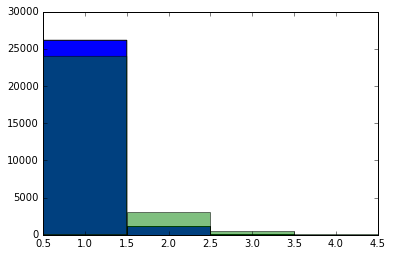

In [6]:
tair_atg_counts = []

for locus_id in tair:
    locus_model = tair[locus_id]
    atg_set = set(locus_model.get_atg_list()[1])
    if len(atg_set) > 2:
        pass
        #print locus_id, locus_model.get_atg_list()
    tair_atg_counts.append(len(atg_set))
    
araport_atg_counts = []

for locus_id in araport:
    locus_model = araport[locus_id]
    try:
        atg_set = set(locus_model.get_atg_list()[1])
        araport_atg_counts.append(len(atg_set))
    except:
        print locus_id, ###

tac = np.array(tair_atg_counts)
tair_2plus_atg = np.sum(tac > 1)
tair_2plus_pcnt = 100* tair_2plus_atg / float(len(tair))
print 'Number of TAIR10 loci with more than one translational start: %d, %.1f %%' %(tair_2plus_atg, tair_2plus_pcnt)
aac =  np.array(araport_atg_counts)
ara_2plus_atg = np.sum(aac > 1)
ara_2plus_pcnt = 100* ara_2plus_atg / float(len(araport))
print 'Number of araport11 loci with more than one translational start: %d, %.1f %%' %(ara_2plus_atg, ara_2plus_pcnt)
    
plt.hist(tair_atg_counts, bins=[0.5,1.5,2.5,3.5,4.5])

plt.hist(araport_atg_counts,bins=[0.5,1.5,2.5,3.5,4.5], alpha=0.5)
plt.show()



# 2. Possible solutions:
## a. Fix ATG at the most common position: 

In [7]:
# Check how many CDS start positions could be determined by a majority position?
def get_majority_atg_tscripts(majority_atg_pos, locus_model):
    majority_atg_tscripts = []
    transcript_dict = locus_model.transcript_dict
    for transcript_id in transcript_dict:
        transcript_model = transcript_dict[transcript_id]
        atg_pos = transcript_model.get_atg()
        if atg_pos == majority_atg_pos:
            majority_atg_tscripts.append(transcript_id)
    return majority_atg_tscripts


def characterise_CDS_starts(locus_dict):
    no_max =[]
    majority_determined= []
    
    for locus_id in locus_dict:
        locus_model = locus_dict[locus_id]
        atg_list = locus_model.get_atg_list()
        atg_set = set(atg_list[1]) # get set of ATG positions
        instance_counts = []

        atg_map = []
        if len(atg_set) == 1:
            majority_determined.extend(locus_model.transcript_dict.keys())
            continue
        for element in atg_set:
            n = atg_list[1].count(element) # for each unique ATG pos. find the number of models containing it
            instance_counts.append(n)
            atg_map.append(element)
        max_n = max(instance_counts)
        
        if instance_counts.count(max_n) > 1: # most frequent atg is not unique
            no_max.append(locus_id)
        else: # find counts for second most common position
            majority_atg_pos = atg_map[instance_counts.index(max_n)]
            majority_atg_tscripts = get_majority_atg_tscripts(majority_atg_pos, locus_model)
            
            majority_determined.extend(majority_atg_tscripts)
            instance_counts.remove(max_n)
            new_max_n = max(instance_counts)     
    return no_max, majority_determined


tair_no_majority_loci, tair_maj_tscripts  = characterise_CDS_starts(tair)
print "Loci in TAIR10 with no majority CDS start:", len(tair_no_majority_loci)

araport_no_majority_loci, araport_maj_tscripts= characterise_CDS_starts(araport)
print "Loci in araport11 with no majority CDS start:", len(araport_no_majority_loci)

tair_maj = set(tair_maj_tscripts)
ara_maj = set(araport_maj_tscripts)
rep_set = set(rep_models.values())

print 'len(tair_maj)',len(tair_maj)
print 'len(ara_maj)',len(ara_maj)
print 'len(tair_maj.intersection(ara_maj))',len(tair_maj.intersection(ara_maj))

print 'len(tair_maj.intersection(rep_set))',len(tair_maj.intersection(rep_set))
print 'len(ara_maj.intersection(rep_set))',len(ara_maj.intersection(rep_set))
print 'len(tair_maj.intersection(ara_maj).intersection(rep_set))',len(tair_maj.intersection(ara_maj).intersection(rep_set))

Loci in TAIR10 with no majority CDS start: 854
Loci in araport11 with no majority CDS start: 1959
len(tair_maj) 33102
len(ara_maj) 41053
len(tair_maj.intersection(ara_maj)) 30673
len(tair_maj.intersection(rep_set)) 26435
len(ara_maj.intersection(rep_set)) 24474
len(tair_maj.intersection(ara_maj).intersection(rep_set)) 24274


Selecting a reference CDS start by selecting the most common among all transcripts will not work universally. There are many loci where there is no unique most common CDS start. However, the information might still be useful for verifying other methods of anchoring the CDS.

In [8]:
# check that the longest ORF(s) match the reference ATG given in TAIR10
# see how that matches the longest transcript
# see how that matches the most common atg


## b. Look for the transcript with the longest CDS and fix the ATG for all other models

TAIR10, no rep model at this locus:  0
araport11, no rep model at this locus:  736

number of rep models 33602
number of tair max orfs 31893
tair max orfs in rep 27075
number of ara max orfs 36559
ara max orfs in rep 25451
overlap of ara max orf and tair max orf 30006


(array([  2.58290000e+04,   1.13800000e+03,   5.64000000e+02,
          6.90000000e+01,   3.30000000e+01,   2.20000000e+01,
          3.00000000e+00,   8.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1. ,   2.4,   3.8,   5.2,   6.6,   8. ,   9.4,  10.8,  12.2,
         13.6,  15. ]),
 <a list of 10 Patch objects>)

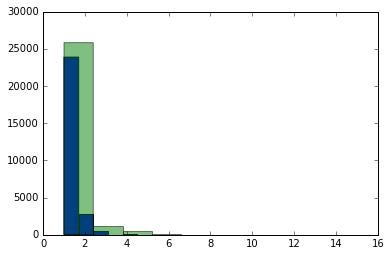

In [9]:
def characterise_max_orfs(rep_models, locus_dict, name):
    missing_counter = 0
    true_counter = 0
    false_counter = 0
    max_orf_transcripts = []
    max_orf_counts = []
    for locus_id in locus_dict:
        locus_model = locus_dict[locus_id]
        orf_data = locus_model.get_orf_lengths()
        max_orf_length = max(orf_data[1]) # finds the maximum value, which may occur more than once
        max_orf_models = []
        max_orf_atg = []
        for i, orf_length in enumerate(orf_data[1]):
            if orf_length == max_orf_length:
                transcript_id = orf_data[0][i]
                max_orf_models.append(transcript_id)
                atg = locus_model.transcript_dict[transcript_id].get_atg()
                max_orf_atg.append(atg)
        if locus_id not in rep_models:
            missing_counter += 1
        elif rep_models[locus_id] in max_orf_models:
            true_counter += 1
        else: false_counter += 1
        if len(set(max_orf_atg)) > 1: # There may be many maximal ORFs: check they all have the same ATG
            print locus_id, len(set(max_orf_atg))
        locus_model.rep_atg = max_orf_atg[0] ####################################################
        locus_dict.update({locus_id:locus_model}) ################################################
        ###############Check max_orf_atg is in all models, otherwise try next max orf

        max_orf_transcripts.extend(max_orf_models)
        n_max_models = len(max_orf_models)
        max_orf_counts.append(n_max_models)
    
    print name + ", no rep model at this locus: ", missing_counter
    return max_orf_transcripts, max_orf_counts, locus_dict
        
        
tair_max_orf_models, tair_n_list, tair = characterise_max_orfs(rep_models, tair, 'TAIR10')
araport_max_orf_models, ara_n_list, araport = characterise_max_orfs(rep_models, araport, 'araport11')


ara_set = set(araport_max_orf_models)
tair_set = set(tair_max_orf_models)
print

x = ara_set.intersection(tair_set)
rep_set = set(rep_models.values())
print "number of rep models", len(rep_set)
print "number of tair max orfs", len(tair_set)


print "tair max orfs in rep",len(tair_set.intersection(rep_set))
print "number of ara max orfs",len(ara_set)

print "ara max orfs in rep",len(ara_set.intersection(rep_set))
print "overlap of ara max orf and tair max orf", len(x)

plt.hist(tair_n_list)
plt.hist(ara_n_list, alpha=0.5)

### Now try max_orf qualified with requirement for atg to be present in all models
avoids problems like this:
https://apps.araport.org/thalemine/report.do?id=2464467

The maximum ORF is only possible in a minority of transcripts due to the alternative splicing of an upstream exon containing an in-frame CDS. The reference ATG should present in as many transcripts as possible.

Next step, where the max ORF does not give a universal ATG, is to move to the next biggest ORF and check whether that satisfies that condition, iteratively.

No universal ATG among annotated CDS models:  147
No universal ATG among annotated CDS models:  415


number of rep models 33602
number of tair max orfs 31881
number of araport max orfs 36557


tair max orfs in rep 26609
araport max orfs in rep 25013
overlap of araport max orf and tair max orf 29360


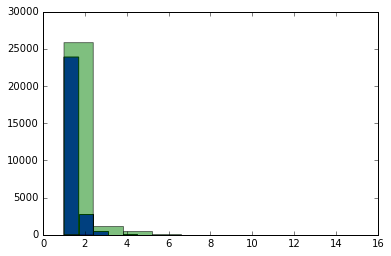

In [10]:
def get_max_atg(orf_data, locus_model):
    max_orf_length = max(orf_data[1]) # finds the maximum value, which may occur more than once
    max_orf_models = []
    max_orf_atg = []
    for i, orf_length in enumerate(orf_data[1]):
        if orf_length == max_orf_length:
            transcript_id = orf_data[0][i]
            max_orf_models.append(transcript_id)
            atg = locus_model.transcript_dict[transcript_id].get_atg()
            max_orf_atg.append(atg)
    assert len(set(max_orf_atg)) == 1
    return max_orf_atg[0], max_orf_models

def check_atg_universal(atg, locus_model):
    transcript_dict = locus_model.transcript_dict
    for transcript_id in transcript_dict:
        atg_present = False
        transcript_model = transcript_dict[transcript_id]
        exon_list=transcript_model.exon_list
        for exon in exon_list:
            if atg in range(exon[0], exon[1]+1):
                atg_present = True
        if atg_present is False:
            return False
    return True


def characterise_max_orfs2(rep_models, locus_dict, name):
    ambiguous_locus = []
    max_orf_transcripts = []
    max_orf_counts = []
    for locus_id in locus_dict:
        locus_model = locus_dict[locus_id]
        orf_data = locus_model.get_orf_lengths()
        
        atg, max_orf_models = get_max_atg(orf_data, locus_model)
        while check_atg_universal(atg, locus_model) is False:
            #remove all instances of current atg
            new_orf_data = [[],[]]
            try:
                max_orf_length = max(orf_data[1])
            except: 
                break
            for i, orf_length in enumerate(orf_data[1]):
                if orf_length != max_orf_length:
                    new_orf_data[0].append(orf_data[0][i])
                    new_orf_data[1].append(orf_data[1][i])
            orf_data = new_orf_data
            try:
                atg, max_orf_models = get_max_atg(orf_data, locus_model)
            except:
                ambiguous_locus.append(locus_id)
                #print locus_id, locus_model.get_orf_lengths()


        locus_dict.update({locus_id:locus_model})


        max_orf_transcripts.extend(max_orf_models)
        n_max_models = len(max_orf_models)
        max_orf_counts.append(n_max_models)

    print "No universal ATG among annotated CDS models: ",len(ambiguous_locus)
        
    return max_orf_transcripts, max_orf_counts, locus_dict
        
        
tair_max_orf_models, tair_n_list, tair = characterise_max_orfs2(rep_models, tair, 'TAIR10')
araport_max_orf_models, ara_n_list, araport = characterise_max_orfs2(rep_models, araport, 'araport11')


ara_set_mod = set(araport_max_orf_models)
tair_set_mod = set(tair_max_orf_models)
print '\n'

x = ara_set.intersection(tair_set_mod)
rep_set = set(rep_models.values())
print "number of rep models", len(rep_set)
print "number of tair max orfs", len(tair_set_mod)
print "number of araport max orfs",len(ara_set_mod)
print '\n'

print "tair max orfs in rep",len(tair_set_mod.intersection(rep_set))

print "araport max orfs in rep",len(ara_set_mod.intersection(rep_set))
print "overlap of araport max orf and tair max orf", len(x)

plt.hist(tair_n_list)
plt.hist(ara_n_list, alpha=0.5)
plt.show()

In [11]:
print len(tair_n_list), len(tair_n_list) -  tair_n_list.count(1)
print len(ara_n_list), len(ara_n_list)- ara_n_list.count(1)

# do these define different ATGs? probably not. 
# did I write a method get_atg() for the transccript class?

27416 3522
27667 5724


## c. Look for the longest transcript at a locus and fix the ATG for all other models

===

max mrna models in tair:  29236
max mrna models in araport:  30938
overlap between max orf and max mrna in tair:  27909
overlap between max orf and max mrna in araport:  27895
overlap between max mrnas in tair and araport:  24521


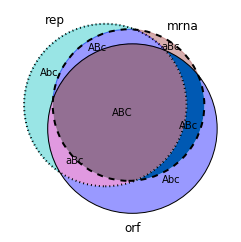

In [12]:
# method of longest mRNA
def characterise_max_mrna(locus_dict):
    max_mrna_models = []
    for locus_id in locus_dict:
        locus_model = locus_dict[locus_id]
        mrna_data = locus_model.mRNA_lengths()
        max_mrna_length = max(mrna_data[1]) # finds the maximum value, which may occur more than once
        max_local_models = []
        for i, mrna_length in enumerate(mrna_data[1]):
            if mrna_length == max_mrna_length:
                max_local_models.append(mrna_data[0][i])
       
        max_mrna_models.extend(max_local_models)
    return max_mrna_models

tair_max_mrna_models = characterise_max_mrna(tair)
araport_max_mrna_models = characterise_max_mrna(araport)

tair_mrna_set = set(tair_max_mrna_models)
ara_mrna_set = set(araport_max_mrna_models)

p = tair_set.intersection(tair_mrna_set)
q= ara_set.intersection(ara_mrna_set)

r = tair_mrna_set.intersection(ara_mrna_set)
##############################################################################################
#                         TIDY THIS UP!                                                      #
##############################################################################################

print '==='
print 
print "max mrna models in tair: ", len(tair_mrna_set)
print "max mrna models in araport: ",len(ara_mrna_set)
print "overlap between max orf and max mrna in tair: ",len(p)
print "overlap between max orf and max mrna in araport: ",len(q)
print "overlap between max mrnas in tair and araport: ",len(r)

A= set(rep_models.values())
B = tair_mrna_set
C = ara_set
# make a function to get subset sizes
#Let A be rep models, B be max mRNA models and C be max ORF models
#Abc

s= calc_venn_sizes(A,B,C)
v = venn3(subsets=s, set_labels=('rep', 'mrna', 'orf'))
format_venn(v)
plt.show()

In [13]:
# show changes in annotation between tair10 and araport11: how different are they?
2venn for each method tried, between tair10 and araport (maybe make tair10 rep 3 venn)


3venn for each database, showing overlap between methods


SyntaxError: invalid syntax (<ipython-input-13-b88150bff0a0>, line 2)

## From araport11:
https://www.araport.org/data/araport11

<table class="dataStatsTable">
<tr class='even'><th></th><th>TAIR10<br />(11/2010)</th><th>Araport11 Pre-release 3<br/>(12/2015)</th></tr>
<tr class='odd'><td>Number of protein coding loci</td><td>27,416</td><td>27,667</td></tr>
<tr class='even'><td>Number of transcripts including isoforms</td><td>35,385</td><td>48,389</td></tr>
<tr class='odd'><td>Number of TAIR10 transcripts with altered CDS</td><td></td><td>1,191 (4.6%)</td></tr>
<tr class='even'><td>Number of TAIR10 transcripts with altered UTRs</td><td></td><td>24,185 (95.4%)</td></tr>
<tr class='odd'><td>Number of loci with splice isoform</td><td>5,665 (18%)</td><td>10,698 (38.7%)</td></tr>
<tr class='even'><td>Number of novel loci</td><td></td><td>719</td></tr>
</table>

In [ ]:
# Once translations have been made, see which loci have changed and check annotations
# translate: 1. RTD2
#             2. TAIR
#             3. Araport
        
# check longest ORF and longest mRNA methods against most common ORF
#check sense of transcript matches sense of locus?

In [ ]:
# assemble AtRTD2 models
def get_models_RTD(gff_lines):
    locus_dict = {}
    for line in gff_lines:
        line=line.strip()
        if line.startswith('#'):
            continue
        line_fields = line.split('\t')
        transcript_ID = line_fields[8].split(';')[0][15:-1]
        locus_ID = line_fields[8].split(';')[1][10:19]

        if not locus_ID.startswith('AT'):
            print line
        
        if locus_ID not in locus_dict:
            gene_model = Gene(locus_ID)
            gene_model.add_sense(line_fields[6])
            locus_dict.update({locus_ID: gene_model})
        else:
            gene_model = locus_dict[locus_ID]
            
        if transcript_ID not in gene_model.transcript_dict:
            transcript_model = Transcript(transcript_ID)
            transcript_model.sense = line_fields[6]
            gene_model.transcript_dict.update({transcript_ID:transcript_model})
        transcript_model = gene_model.transcript_dict[transcript_ID]    
  
        if line_fields[2] == 'CDS':# and proteinCoding == True:
            cds_coords = [int(line_fields[3]), int(line_fields[4])]
            transcript_model.add_CDS(cds_coords)

        if line_fields[2] == 'exon':# and proteinCoding == True:
            exon_coords = [int(line_fields[3]), int(line_fields[4])]
            transcript_model.add_exon(exon_coords)
        
        gene_model.transcript_dict.update({transcript_ID:transcript_model})
        locus_dict.update({locus_ID: gene_model})
    return locus_dict


infile = open('./AtRTD2_19April2016.gtf', 'rU')
gff_lines = infile.readlines()
infile.close()
atRTD2 = get_models_RTD(gff_lines)

###########################################################################
# add sequences to atRTD2 models

infile = open('./AtRTD2_19April2016.fa', 'rU')
for line in infile:
    line = line.strip()
    if line.startswith('>'):
        seq = ''
        line = line.split(' ')
        model_id = line[0][1:]
        gene_id = line[0][1:10] 

        gene_model = atRTD2[gene_id]
        transcript_model = gene_model.transcript_dict[model_id]
    
    else:
        transcript_model.seq += line
infile.close()

In [14]:
# move this up to the transcript model

def translate_seq(sequence):
    'Returns the amino acid translation of a given sequence'
    codon_table = {'TTT':'F', 'TTC':'F', 'TTA':'L', 'TTG':'L', 
                   'TCT':'S', 'TCC':'S', 'TCA':'S', 'TCG':'S',
                   'TAT':'Y', 'TAC':'Y', 'TAA':'*', 'TAG':'*', 
                   'TGT':'C', 'TGC':'C', 'TGA':'*', 'TGG':'W',
                   'CTT':'L', 'CTC':'L', 'CTA':'L', 'CTG':'L', 
                   'CCT':'P', 'CCC':'P', 'CCA':'P', 'CCG':'P',
                   'CAT':'H', 'CAC':'H', 'CAA':'Q', 'CAG':'Q', 
                   'CGT':'R', 'CGC':'R', 'CGA':'R', 'CGG':'R', 
                   'ATT':'I', 'ATC':'I', 'ATA':'I', 'ATG':'M', 
                   'ACT':'T', 'ACC':'T', 'ACA':'T', 'ACG':'T',
                   'AAT':'N', 'AAC':'N', 'AAA':'K', 'AAG':'K', 
                   'AGT':'S', 'AGC':'S', 'AGA':'R', 'AGG':'R',
                   'GTT':'V', 'GTC':'V', 'GTA':'V', 'GTG':'V', 
                   'GCT':'A', 'GCC':'A', 'GCA':'A', 'GCG':'A',
                   'GAT':'D', 'GAC':'D', 'GAA':'E', 'GAG':'E', 
                   'GGT':'G', 'GGC':'G', 'GGA':'G', 'GGG':'G'}
    codon_pos = 0
    trans = ''
    while codon_pos < (len(sequence) - 2):     
        codon = sequence[codon_pos:codon_pos + 3]
        if codon in codon_table:
            aa = codon_table[codon]
        else:
            aa = 'x'
        trans = trans + aa
        if aa == '*':
            return trans
        codon_pos += 3
    return trans


In [15]:
def quick_cds():
    '''
    only the start and stop positions
    '''
    
    
    
def full_cds():
    '''
    list each exon portion of the cds, including phase
    Chr1	Araport11	gene	6788	9130	.	-	.	ID=AT1G01020;Name=AT1G01020;Note=ARV1 family protein
    Chr1	Araport11	mRNA	6788	8737	.	-	.	ID=AT1G01020.2;Parent=AT1G01020;Note=ARV1 family protein
    Chr1	Araport11	CDS	7315	7450	.	-	1	ID=AT1G01020:CDS:10;Parent=AT1G01020.2
    Chr1	Araport11	CDS	7564	7649	.	-	0	ID=AT1G01020:CDS:8;Parent=AT1G01020.2
    Chr1	Araport11	CDS	7762	7835	.	-	2	ID=AT1G01020:CDS:7;Parent=AT1G01020.2
    '''
    line = '{seqid} \t {source} \t {type} \t {start} \t {end} \t {score} \t {strand} \t {phase} \t {attributes}'
    seqid

In [16]:
line = '{seqid} \t {source} \t {type} \t {start} \t {end} \t {score} \t {strand} \t {phase} \t {attributes} \n'

details ={'seqid':'ab', 'source':'cd','type':'ef','start':4, 'end':6, 'score':'.','strand':'+', 'phase':0, 'attributes':'test'}

print line.format(**details)

ab 	 cd 	 ef 	 4 	 6 	 . 	 + 	 0 	 test 



In [17]:
outfile = open('./peptides_29jun16.fa','wb')


absent_araport = []
nay=[]
no_exon_counter = 0
rep_atg_absent = []
model_count = 0
retro_transposons = []
for locus_id in sorted(atRTD2.keys()):
    if locus_id not in araport:
        absent_araport.append(locus_id)
        continue
    if araport[locus_id].transposon is True:
        retro_transposons.append(locus_id)
        continue
    atg_pos = araport[locus_id].rep_atg
    gene_model = atRTD2[locus_id]
    transcript_dict = gene_model.transcript_dict
    for transcript_id in transcript_dict:
        model_count += 1
        
        transcript_model = transcript_dict[transcript_id]
######################################################################
# move this into a function, or even into transcript model
        if transcript_model.sense == '+':
            exon_list = transcript_model.exon_list
        else:
            exon_list = transcript_model.exon_list[::-1]

        cds_index = 0
        z = False
        for exon in exon_list:
            if atg_pos not in range(exon[0],exon[1]+1):
                cds_index +=  1+exon[1] - exon[0]
            else:
                if transcript_model.sense == '+':
                    cds_index += atg_pos - exon[0]
                    z = True
                    break
                else:
                    cds_index += exon[1] - atg_pos
                    z = True
                    break    
        if z is False:
            rep_atg_absent.append(transcript_id)
            continue
        seq = transcript_model.seq[cds_index:]
######################################################################
        
        
        if not seq.startswith('ATG'):
            nay.append(transcript_id)
            continue

            print transcript_id
            print seq
            print exon_list
            print atg_pos
            print cds_index
            
            raise(AssertionError)
        else:
            peptide = translate_seq(seq)
            outfile.writelines('>'+transcript_id+'\n')
            outfile.writelines(peptide+'\n\n')
            
outfile.close()
print "locus id not in araport", len(absent_araport)           
print "rep atg not in transcript",len(rep_atg_absent)
print "transposon loci", len(retro_transposons)
print "total models considered", model_count
print len(nay)

NameError: name 'atRTD2' is not defined

In [18]:
for i in absent_araport[:2]:
    print i

In [19]:
for i in rep_atg_absent[:2]:
    print i
    
'AT4G38440.4' in rep_atg_absent

False

In [20]:
for i in retro_transposons:
    print i

In [ ]:
# For loci not in araport, presumably these are not protein encoding
# For cases where ATG is not present: who knows? Re-run the longest ORF-finding program using atRTD2 transcripts?
# Last time, there were several antisense transcripts

#locus id not in araport 6635
#rep atg not in transcript 4339
#transposon loci 37
#total models considered 74151
#90